# Linear Modelling

### Notebook Summary
This notebook will detail the implementation of linear models, linear regression will be implemented as the baseline model. The performance of which will provide insights into which models to implement next to improve performance.

## Notebook Setup

In [3]:
# Standard imports
import numpy as np
import math as math
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scipy.stats as stats


# Loading sklearn functionality
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Set global random seed for reproducibility
random_seed_val = 42
np.random.seed(random_seed_val)

In [4]:
# Columns to scale
cols_to_scale = ['bathrooms', 'floorAreaSqM', 'livingRooms']

# Scaling function
def scaler_function(df, cols_to_scale, scaler=None, fit=False):
    """
    Scales specified columns in a single DataFrame.
    
    Parameters:
    - df: DataFrame to scale
    - cols_to_scale: List of column names to scale
    - scaler: A fitted or unfitted sklearn StandardScaler instance 
    - fit: If True, fit the scaler on this DataFrame. If False, just transform.
    
    Returns:
    - df_scaled: DataFrame with scaled columns
    - scaler: The fitted scaler object
    """
    if scaler is None:
        scaler = StandardScaler()
    
    df_copy = df.copy()

    if fit:
        scaler.fit(df_copy[cols_to_scale])

    scaled_values = scaler.transform(df_copy[cols_to_scale])
    scaled_df = pd.DataFrame(scaled_values, columns=cols_to_scale, index=df_copy.index)

    df_copy.drop(cols_to_scale, axis=1, inplace=True)
    df_scaled = pd.concat([scaled_df, df_copy], axis=1)

    return df_scaled, scaler

## Data Loading & Understanding

In [5]:
# Creating DataFrame
pp_house_df = pd.read_csv(r'C:\Users\sanja\capstone-SanjayRaju2000\src\data\london_house_price_data_pp.csv')
# Viewing DataFrame
pp_house_df.head(5)

,latitude,longitude,bathrooms,floorAreaSqM,livingRooms,saleEstimate_currentPrice,tenure_Feudal,tenure_Leasehold,tenure_Shared,propertyType_Detached,propertyType_Semi-Detached,propertyType_Terraced,currentEnergyRating_encoded
0,51.495505,-0.132379,2.0,71.0,1.0,759000.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
1,51.478185,-0.092201,1.0,64.0,1.0,388000.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
2,51.588774,-0.139599,1.0,137.0,2.0,1261000.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
3,51.466089,0.006967,1.0,97.0,1.0,944000.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
4,51.451327,-0.007569,1.0,135.0,2.0,726000.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0


In [6]:
# Columns and data types
pp_house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265193 entries, 0 to 265192
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   latitude                     265193 non-null  float64
 1   longitude                    265193 non-null  float64
 2   bathrooms                    265193 non-null  float64
 3   floorAreaSqM                 265193 non-null  float64
 4   livingRooms                  265193 non-null  float64
 5   saleEstimate_currentPrice    265193 non-null  float64
 6   tenure_Feudal                265193 non-null  float64
 7   tenure_Leasehold             265193 non-null  float64
 8   tenure_Shared                265193 non-null  float64
 9   propertyType_Detached        265193 non-null  float64
 10  propertyType_Semi-Detached   265193 non-null  float64
 11  propertyType_Terraced        265193 non-null  float64
 12  currentEnergyRating_encoded  265193 non-null  float64
dtyp

In [7]:
# Shape of the DataFrame
pp_house_df.shape

(265193, 13)

## Preparing Data

In [8]:
# Seperating features from target
X = pp_house_df.drop(['latitude', 'longitude', 'saleEstimate_currentPrice'], axis=1)
y = pp_house_df['saleEstimate_currentPrice']

Latitude and Longitude were columns which showed no linear relationship with the target column, inclusion of these features would not have satisfied the first assumption of linear regression.

In [9]:
# Shape of the DataFrame
X.shape

(265193, 10)

In [10]:
# Remainder test split
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.20, random_state=random_seed_val)

# Train validation split
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size=0.20, random_state=random_seed_val)

# Checking size of split
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_valid)}") 
print(f"Test set size: {len(X_test)}")

Training set size: 169723
Validation set size: 42431
Test set size: 53039


## Linear Regression 

Linear regression is a good baseline model for this problem because it is simple, interpretable, and provides a quick measure of how well the features explain variance in house prices. Although the assumption of a perfect linear relationship between features and target is not fully satisfied, linear regression can still capture general trends and highlight key feature importance. It serves as a strong starting point before moving to more complex models. Default hyperparameters are used to maintain simplicity and avoid early overfitting, ensuring the baseline results reflect the natural behavior of the model without additional tuning.


#### Linear Regression - Performance

In [11]:
# Defining model
lin_reg_model = LinearRegression()

# Fitting model
lin_reg_model.fit(X_train, y_train)

# Scoring on train
train_score = lin_reg_model.score(X_train, y_train)

# Scoring on validation
valid_score = lin_reg_model.score(X_valid, y_valid)

# Cross validation score
cross_score = np.mean(cross_val_score(lin_reg_model, X_remainder, y_remainder, cv=5))

# Print performance
print(f"R^2 value for the training is {train_score}") 
print(f"R^2 value for the validation is {valid_score}")
print(f"R^2 value for five fold cross validation is {cross_score}")


R^2 value for the training is 0.6247443485879365
R^2 value for the validation is 0.6178653185811109
R^2 value for five fold cross validation is 0.6232300258954075


The baseline linear regression model achieved an R² of approximately 0.62 across training, validation, and five-fold cross-validation sets. Indicating that the model explains around 62% of the variance in house prices, which is a good result for a first-pass model without hyperparameter tuning. 

The close alignment between training and validation R² values suggests that the model is not overfitting and generalizes reasonably well to unseen data. Although there is still substantial unexplained variance, this baseline provides a strong foundation for further improvement through hyperparameter tuning. 


#### Linear Regression - Model Coefficients

In [12]:
# Coefficients
lin_reg_model.coef_

# Coefficient and Feature DataFrame
coeff_df = pd.DataFrame(lin_reg_model.coef_, index=X_train.columns, columns = ["Coefficient"] )

# Reset index to turn the index into a column
coeff_df.reset_index(inplace=True)

# Rename columns appropriately
coeff_df.columns = ['Feature', 'Coefficient']

# Display DataFrame
coeff_df.head()

,Feature,Coefficient
0,bathrooms,262993.653798
1,floorAreaSqM,9428.508948
2,livingRooms,67674.023723
3,tenure_Feudal,238553.127811
4,tenure_Leasehold,225317.340360


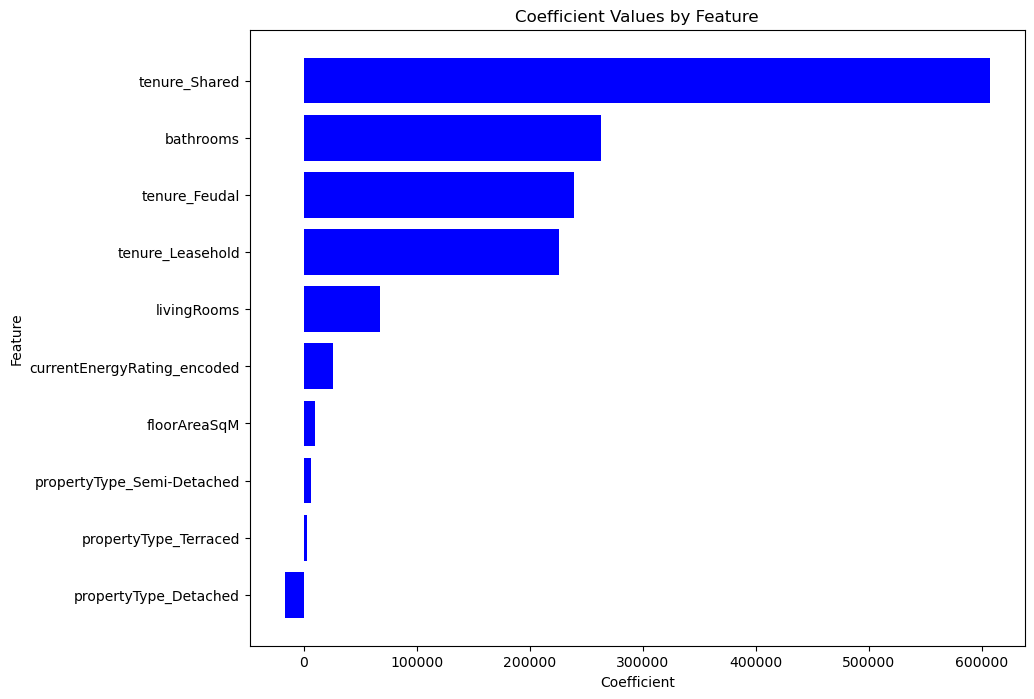

In [13]:
# Sort Coefficients in ascending order
coeff_df = coeff_df.sort_values(by='Coefficient')

# Create a bar chart
plt.figure(figsize=(10, 8))  
plt.barh(coeff_df['Feature'], coeff_df['Coefficient'], color='blue')  
plt.xlabel('Coefficient') 
plt.ylabel('Feature')  
plt.title('Coefficient Values by Feature')  
plt.show()  


- Coefficients Plot Observations:
  - Most features show logical relationships with property price.

- Anomalies:
  - Floor area (sqm), which should logically be one of the strongest predictors of price, has a relatively small coefficient.
  - Tenure_Shared, a categorical variable, dominates the model with a very large coefficient.
  - Current energy rating, despite showing little direct relationship to price in EDA, has a higher coefficient than key features like semi-detached, terraced, and detached property types.

- Possible causes:
  - Lack of feature scaling, features are on different scales which may be affecting coefficient sizes. Variables with small ranges (variables from one-hot encoding) often receive larger coefficients compared to continuous variables with wider ranges.
  - Omitting variable bias, dropping latitude and longitude, may have lead to distorted coefficients as the model tries to explain variation it cannot properly attribute.
  - One-hot encoded categorical variables like tenure can create large jumps in predicted price, leading to inflated coefficient magnitudes.

- Nest Steps:
  - Regularisation to shrink and balance coefficient magnitudes.
  


#### Linear Regression - Evaluation

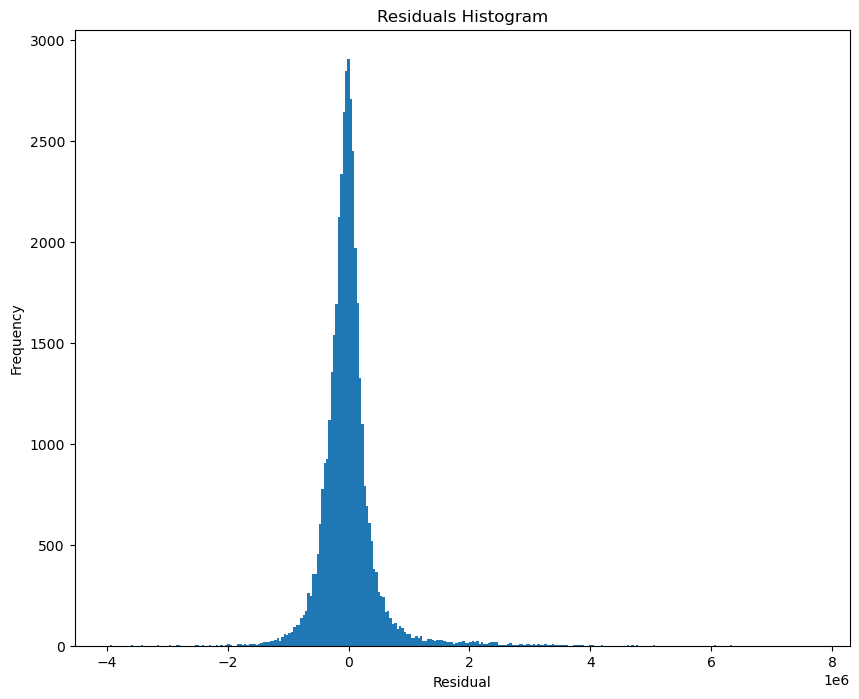

In [14]:
# Predict on validation set
y_pred = lin_reg_model.predict(X_valid)

# Residuals (true - predicted)
residuals = y_valid - y_pred

# Plot histogram of residuals
plt.figure(figsize=(10, 8))
plt.hist(residuals, bins=300)
plt.title('Residuals Histogram')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

Histogram Plot Observations:

The distribution of the residuals follows a normal distribution, aligning with the normality assumption of linear regression. The lack of skewness and the concentration of most residuals around zero indicate a good model fit with minimal bias.

In [15]:
# Calculate mean and standard deviation
norm_mean_residual = (np.mean(residuals)/np.mean(y_valid)) 
norm_std_residual = (np.std(residuals)/np.mean(y_valid))

print(f"Normalised mean of residuals: {norm_mean_residual:.4f}")
print(f"Normalised standard deviation of residuals: {norm_std_residual:.4f}")

Normalised mean of residuals: -0.0035
Normalised standard deviation of residuals: 0.5700


The normalised mean residuals being close to zero suggests that the baseline model is unbaised, however the normalised standard deviation which exceeds 0.5 indicates high variance. Further improvement of this model is required.

In [16]:
# Model Evaluation Metrics

# Calculate Coefficient of Variation Root Mean Squared Error
mse = mean_squared_error(y_true=y_valid, y_pred=y_pred)
rmse = math.sqrt(mse)
rmse_coeff_var = (rmse/np.mean(y_valid))
print(f"The Coefficient of Variation Root Mean Squared Error: {rmse_coeff_var:.4f}")

# Calculate Normalised Mean Absolute Error
mae = mean_absolute_error(y_true=y_valid, y_pred=y_pred)
norm_mae = (mae/np.mean(y_valid))
print(f"The Normalised Mean Absolute Error: {norm_mae:.4f}")

The Coefficient of Variation Root Mean Squared Error: 0.5700
The Normalised Mean Absolute Error: 0.3262


The Coefficient of Variation Root Mean Squared Error being 0.57 suggests that there is moderate variablilty relative to the mean of the target.
The model's prediction errors are more than half the size of the mean of the target. Significant error indicating that the model requires further refinement.

The Normalised Mean Absolute Error indicates that the average prediction error is roughly one-third of the mean value of the target, suggesting that the model’s predictions are relatively close to the actual values.

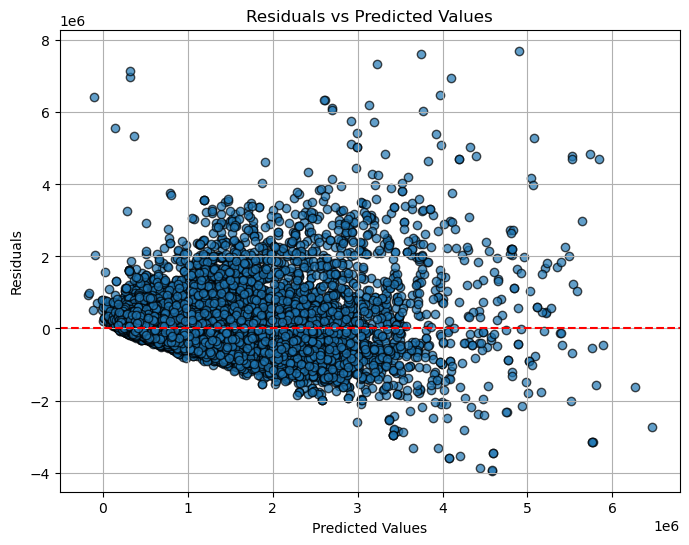

In [17]:
# Plot residuals vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7, edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--')  # horizontal line at 0
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

Scatter Plot Observations:

Homoscedastic relationship percieved between the predicted values and the residuals, satisfying the final assumption of linear regression.

#### Linear Regression - Reflection
The base model meets the assumptions for linear regression and achieves an R-squared of 0.62. However, the coefficients may not fully capture key predictive features. A normalised MAE of 32.62% indicates moderate prediction variability, suggesting further refinement is needed to improve predictive performance and representation of significant features.

## Ridge Regression

Ridge Regression adds L2 regularization, penalising large coefficients. This helps stabilize the model by shrinking anomalous coefficients. As a result, Ridge can improve generalization and potentially boost performance by making the model less sensitive to noise.


#### Ridge Regression - Validation set method

In [18]:
# Make copy of data before scaling
X_train_ridge = X_train.copy()
X_valid_ridge = X_valid.copy()

# Define alpha values
alpha_values = [10**i for i in range(-10, 11)]

# Dictionary to hold scores for each alpha
ridge_scores = {}

# Scaling train data
X_train_scaled, trained_scaler = scaler_function(X_train_ridge, cols_to_scale, fit=True)

# Scaling validation data
X_valid_scaled, _ = scaler_function(X_valid_ridge, cols_to_scale, scaler=trained_scaler)


for alpha in alpha_values:
    # Instantiate model with alpha value
    ridge_model = Ridge(alpha=alpha)

    # Fit model on scaled training data
    ridge_model.fit(X_train_scaled, y_train)

    # Score model on scaled training and validation data
    train_score_val = ridge_model.score(X_train_scaled, y_train)
    valid_score_val = ridge_model.score(X_valid_scaled, y_valid)

    # Store scores in dictionary under the alpha key
    ridge_scores[alpha] = {'train_score': train_score_val, 'valid_score': valid_score_val}

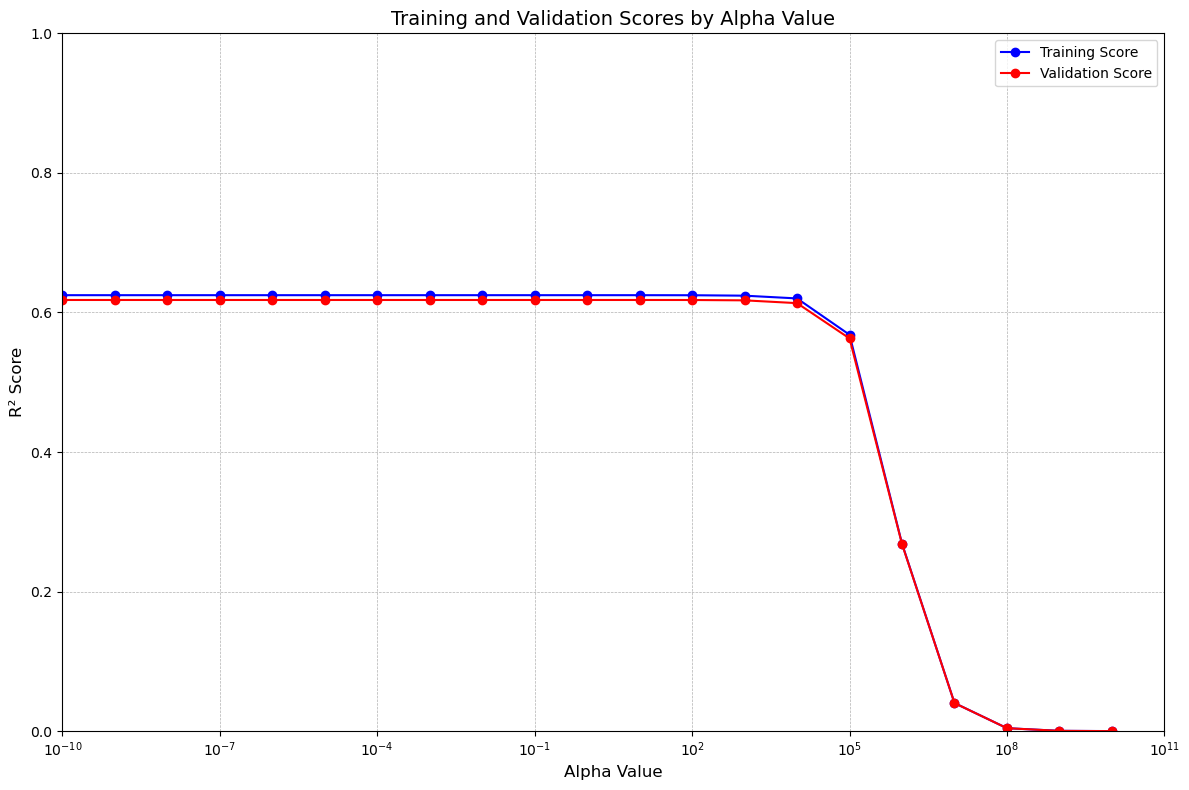

In [19]:
# Plotting scores against alpha
plt.figure(figsize=(12, 8))

# Prepare training and validation scores
train_scores = [ridge_scores[alpha]['train_score'] for alpha in alpha_values]
valid_scores = [ridge_scores[alpha]['valid_score'] for alpha in alpha_values]

# Plot with markers
plt.plot(alpha_values, train_scores, color='blue', marker='o', label='Training Score')
plt.plot(alpha_values, valid_scores, color='red', marker='o', label='Validation Score')

# Logarithmic x-axis
plt.xscale('log')

# Axis limits
plt.xlim(left=1e-10)
plt.ylim(0, 1.0)

# Labels and title
plt.xlabel('Alpha Value', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Training and Validation Scores by Alpha Value', fontsize=14)

# Grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

- Scatter Plot Observations:
  - Closely fit curves suggest no overfitting and good generalization.

- R-squared performance:
  - At low alpha, R^2 is around 0.62, showing a good bias-variance balance.

- Effect of increasing alpha:
  - As alpha increases, coefficients shrink due to stronger regularization.
  - Very high alpha values cause underfitting, with R^2 dropping to zero.
  - Alpha value of 100 or 1000 seems optimal.


#### Ridge Regression - Cross validation method

In [20]:
# Store the results
cross_validation_scores = []

# Make copy of data before scaling
X_remainder_ridge_cv = X_remainder.copy()

# Scaling
X_remainder_scaled_cv, trained_scaler = scaler_function(X_remainder_ridge_cv, cols_to_scale, fit=True)


for alpha in alpha_values:
    # Instantiate model with alpha value
    ridge_model_cv = Ridge(alpha=alpha)

    # Fit model on scaled training data
    ridge_model_cv.fit(X_remainder_scaled_cv, y_remainder)

    # The cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(ridge_model_cv, X_remainder_scaled_cv, y_remainder, cv=5))

    # Append the score
    cross_validation_scores.append(cv_score)

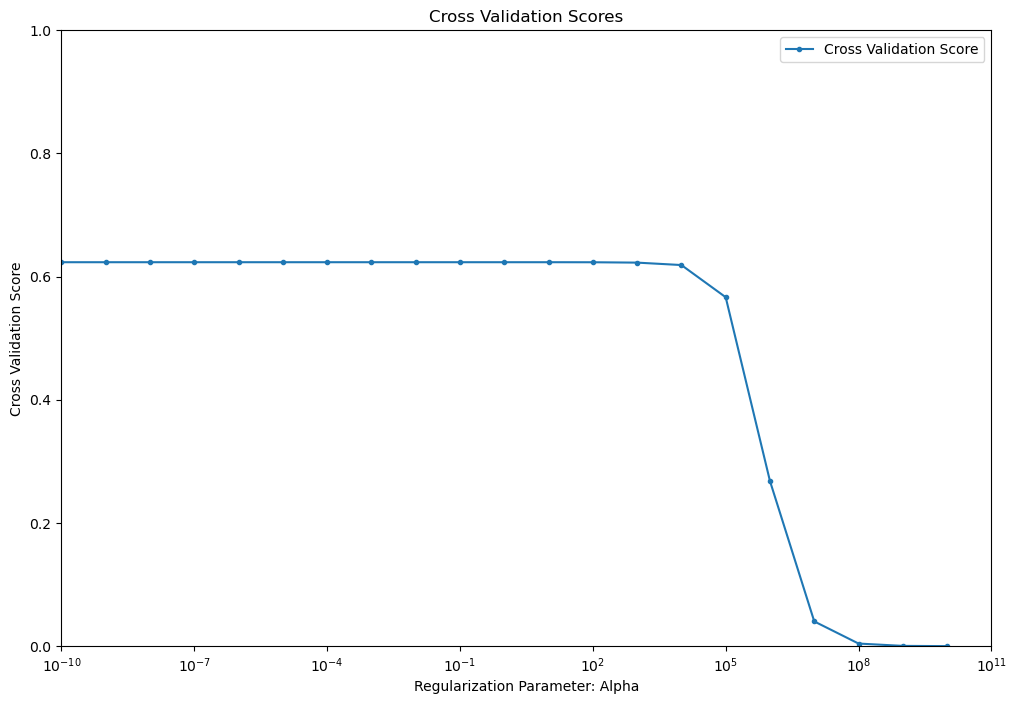

In [21]:
# Plotting scores against alpha

# Scatter plot
plt.figure(figsize=(12, 8))
plt.plot(alpha_values, cross_validation_scores, label="Cross Validation Score", marker=".")

# Logarithmic scale for the x-axis
plt.xscale("log")

# Set x-axis and y-axis limits
plt.xlim(left=1e-10) 
plt.ylim(bottom=0, top=1.0)

# Labels and Title
plt.xlabel("Regularization Parameter: Alpha")
plt.ylabel("Cross Validation Score")
plt.title("Cross Validation Scores")
plt.legend()

# Show plot
plt.show()


- Cross-validation scatter plot:
  - As alpha increases beyond a certain threshold, R² drops rapidly, showing clear signs of underfitting.
  - The drop is not gradual but sharp, suggesting that the model's capacity to fit the underlying patterns collapses quickly once regularization becomes too strong.

- Importance of cross-validation:
  - Cross-validation helps confirm that the pattern of underfitting at high alpha values is not due to randomness but a genuine model behavior.

#### Ridge Regression - Final model

In [22]:
# Final model evaluation with the test set

# Make copy of data before scaling
X_train_ridge_final = X_train.copy()
X_valid_ridge_final = X_valid.copy()

# Scaling remainder data
X_train_scaled_final, trained_scaler = scaler_function(X_train_ridge_final, cols_to_scale, fit=True)

# Scaling test data
X_valid_scaled_final, _ = scaler_function(X_valid_ridge_final, cols_to_scale, scaler=trained_scaler)

# Testing optimal model:

# Instantiate model with alpha value
# alpha value higher than optimal
final_ridge_model = Ridge(alpha=1000)

# Fit model on scaled train data
final_ridge_model.fit(X_train_scaled_final, y_train)

# Test
print(f"R^2 Value for final ridge model: {final_ridge_model.score(X_valid_scaled_final, y_valid):.4f}")

R^2 Value for final ridge model: 0.6173


#### Ridge Regression - Final Model Coefficients

In [23]:
# Features
features = X_valid_scaled_final.columns

# Extract coefficients from the best model
ridge_coefficients = final_ridge_model.coef_

# Create a DataFrame for coefficients
coefficients_df = pd.DataFrame({
    'Feature': X_valid_scaled_final.columns,  # Feature names
    'Coefficient': ridge_coefficients  # Coefficients
})

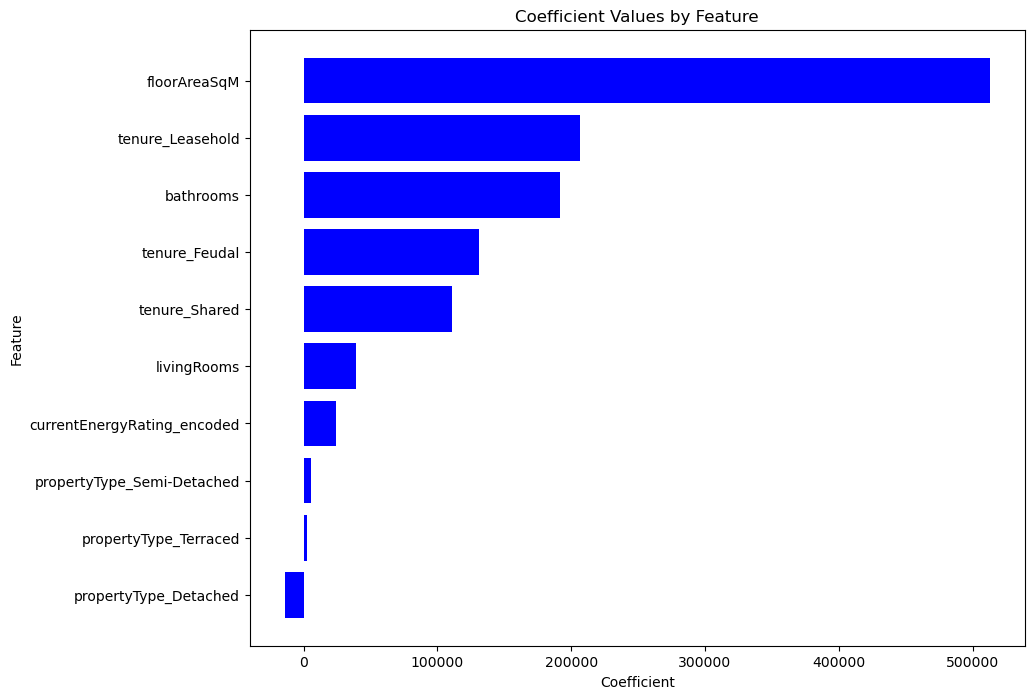

In [24]:
# Sort Coefficients in ascending order
coefficients_df = coefficients_df.sort_values(by='Coefficient')

# Create a bar chart
plt.figure(figsize=(10, 8))  
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='blue')  
plt.xlabel('Coefficient') 
plt.ylabel('Feature')  
plt.title('Coefficient Values by Feature')  
plt.show()  

- Observations from Ridge regression coefficients:
  - Ridge corrected some major distortions in coefficients.
  - Floor area now has the highest coefficient, matching expectations for property size impact.
  - Current Energy Rating correctly has a far lower coefficient.

- Key insights:
  - Feature importance is more logical, with floor area, tenure, and bathrooms ranked highest.
  - Tenure variables still show strong influence, even after regularization.
  - Current energy rating remains higher than expected, suggesting proxy effects were reduced but not removed.
  - Property types rank lower, likely due to their smaller incremental impact once size and tenure are considered.

- Anomalies:
  - The lowest coefficients belong to one-hot encoded property types: semi-detached, terraced, and detached.
    Possible reasons:
    - Much of the information from property type may already be captured by other features, reducing its unique impact.
    - Regularization shrinks signals, further lowering the influence of property type.

- Further insights:
  - Ridge stabilizes coefficients but cannot fully remove hidden biases from certain features.
  - High tenure coefficients suggest ownership type holds independent predictive power.
  - Features creating discrete price jumps (like tenure) are less affected by regularization than continuous features.


#### Ridge Regression - Evaluation

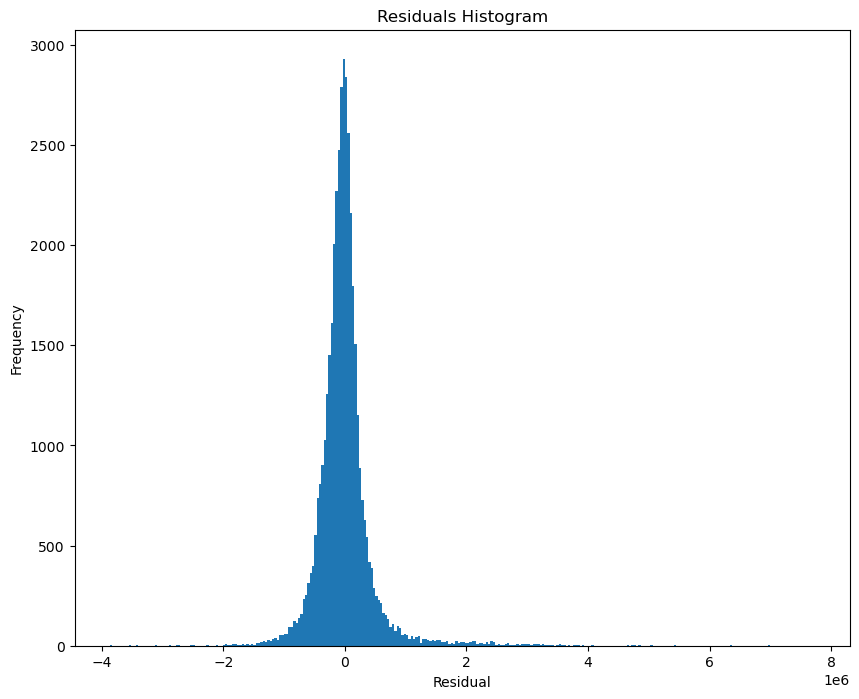

In [25]:
# Predict on validation set
y_pred_ridge = final_ridge_model.predict(X_valid_scaled_final)

# Residuals (true - predicted)
ridge_residuals = y_valid - y_pred_ridge

# Plot histogram of residuals
plt.figure(figsize=(10, 8))
plt.hist(ridge_residuals, bins=300)
plt.title('Residuals Histogram')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Calculate mean and standard deviation
ridge_norm_mean_residual = (np.mean(ridge_residuals)/np.mean(y_valid)) 
ridge_norm_std_residual = (np.std(ridge_residuals)/np.mean(y_valid))

print(f"Normalised mean of residuals: {ridge_norm_mean_residual:.4f}")
print(f"Normalised standard deviation of residuals: {ridge_norm_std_residual:.4f}")

Normalised mean of residuals: -0.0037
Normalised standard deviation of residuals: 0.5703


In [ ]:
# Model Evaluation Metrics

# Calculate Coefficient of Variation Root Mean Squared Error
mse_ridge = mean_squared_error(y_true=y_valid, y_pred=y_pred_ridge)
rmse_ridge = math.sqrt(mse_ridge)
rmse_coeff_var_ridge = (rmse_ridge/np.mean(y_valid))
print(f"The Coefficient of Variation Root Mean Squared Error: {rmse_coeff_var_ridge:.4f}")

# Calculate Normalised Mean Absolute Error
mae_ridge = mean_absolute_error(y_true=y_valid, y_pred=y_pred_ridge)
norm_mae_ridge = (mae_ridge/np.mean(y_valid))
print(f"The Normalised Mean Absolute Error: {norm_mae_ridge:.4f}")

The Coefficient of Variation Root Mean Squared Error: 0.5704
The Normalised Mean Absolute Error: 0.3252


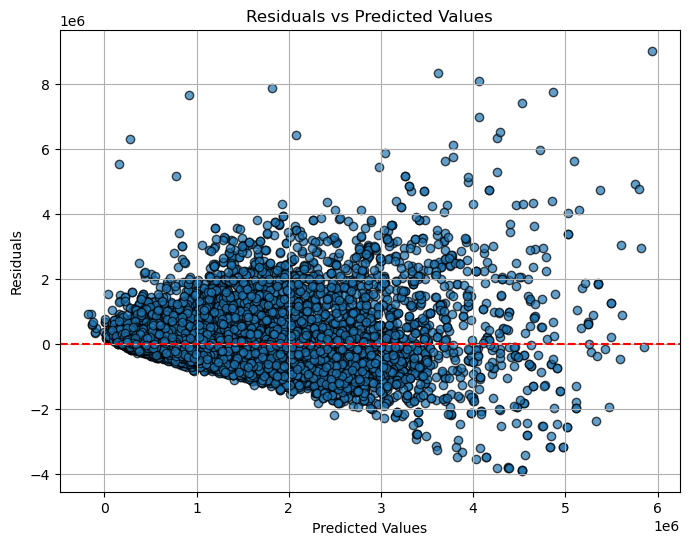

In [ ]:
# Plot residuals vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_ridge, ridge_residuals, alpha=0.7, edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--')  # horizontal line at 0
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

#### Ridge Regression - Reflection
Despite switching to Ridge regression, evaluation metrics like normalized mean of residuals, standard deviation, coefficient of variation RMSE, and normalized MAE remain similar to the baseline linear model. While Ridge improves coefficient interpretability, it has little effect on predictive performance or residual distribution. This suggests alternative modeling approaches are required to improve results.

### Linear Modelling Conclusion

Ridge regression improved coefficient stability but did not change evaluation metrics compared to the baseline linear model, as regularization affects interpretability rather than the model’s ability to capture complex patterns. Dropping features like latitude and longitude likely caused a loss of important spatial information, limiting predictive performance. Overall, the results indicate that linear models are insufficient, and non-linear modeling approaches are needed to better capture the underlying relationships.